In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re

pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid")


In [2]:

file_path = r"Data\newsData\raw_analyst_ratings.csv"

df = pd.read_csv(file_path)

print("Dataset loaded successfully! Shape:", df.shape)
df.head()


Dataset loaded successfully! Shape: (1407328, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/stocks-that-hit-52-week-highs-on-friday,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/stocks-that-hit-52-week-highs-on-wednesday,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/71-biggest-movers-from-friday,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/46-stocks-moving-in-fridays-mid-day-session,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,"B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88",https://www.benzinga.com/news/20/05/16095304/b-of-a-securities-maintains-neutral-on-agilent-technologies-raises-price-target-to-88,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df["date"] = pd.to_datetime(df["date"], errors="coerce")

df["headline_length"] = df["headline"].astype(str).apply(len)

df.head()


,headline,url,publisher,date,stock,headline_length
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/stocks-that-hit-52-week-highs-on-friday,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/stocks-that-hit-52-week-highs-on-wednesday,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/71-biggest-movers-from-friday,Lisa Levin,2020-05-26 04:30:07-04:00,A,29
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/46-stocks-moving-in-fridays-mid-day-session,Lisa Levin,2020-05-22 12:45:06-04:00,A,44
4,"B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88",https://www.benzinga.com/news/20/05/16095304/b-of-a-securities-maintains-neutral-on-agilent-technologies-raises-price-target-to-88,Vick Meyer,2020-05-22 11:38:59-04:00,A,87


In [4]:
print(" Headline Length Statistics:")
display(df["headline_length"].describe())

print("\n Number of Articles Per Publisher:")
publisher_counts = df["publisher"].value_counts()
display(publisher_counts)

print("\n Date Range of Publications:")
print("Earliest date:", df["date"].min())
print("Latest date:", df["date"].max())

print("\n Articles Per Day:")
articles_per_day = df.groupby(df["date"].dt.date).size()
display(articles_per_day.head())


 Headline Length Statistics:


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


 Number of Articles Per Publisher:


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


 Date Range of Publications:
Earliest date: 2011-04-27 21:01:48-04:00
Latest date: 2020-06-11 17:12:35-04:00

 Articles Per Day:


date
2011-04-27    1
2011-04-28    2
2011-04-29    2
2011-04-30    1
2011-05-01    1
dtype: int64

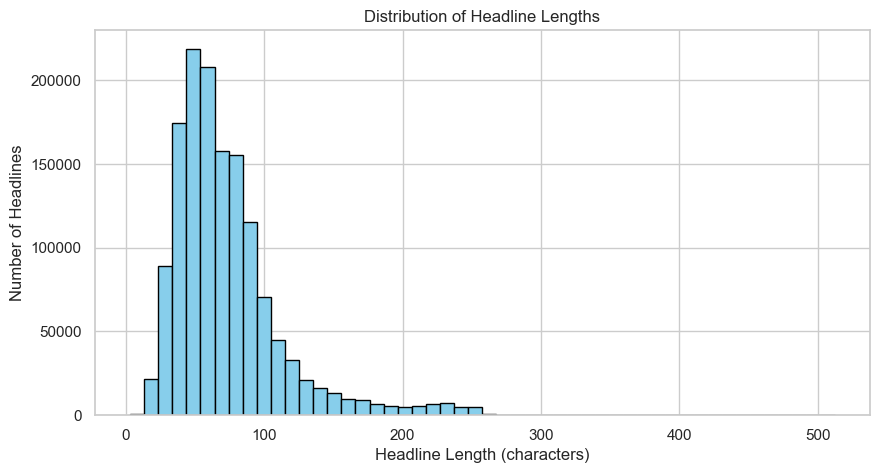

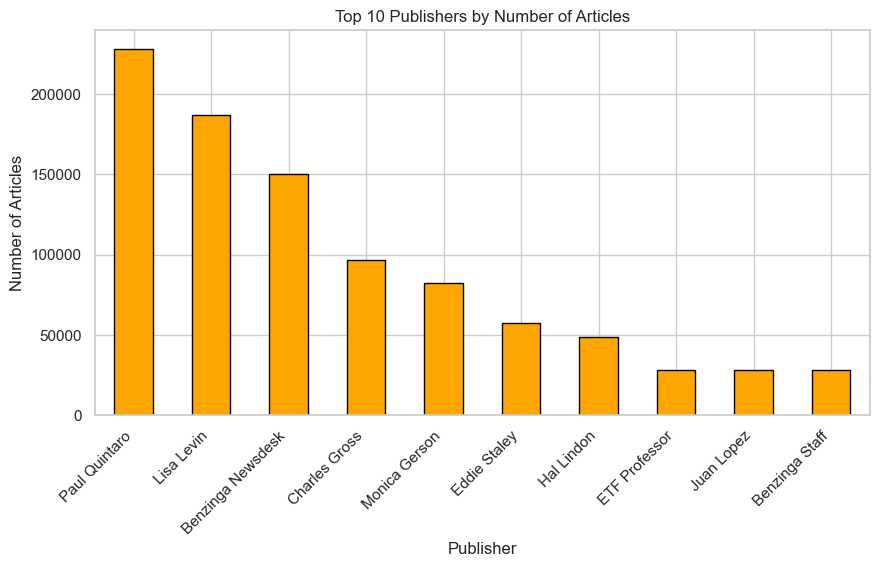

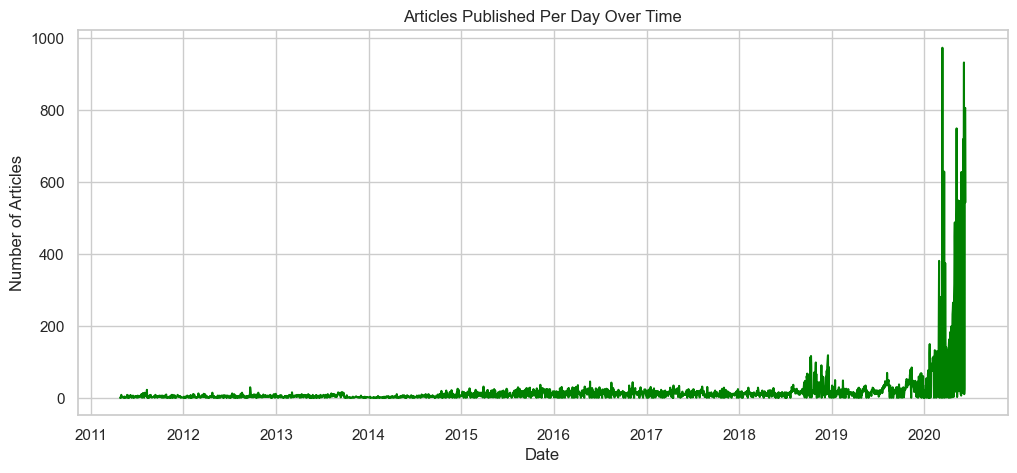

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(df["headline_length"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Headline Lengths")
plt.xlabel("Headline Length (characters)")
plt.ylabel("Number of Headlines")
plt.show()

top_publishers = df["publisher"].value_counts().head(10)
plt.figure(figsize=(10, 5))
top_publishers.plot(kind="bar", color="orange", edgecolor="black")
plt.title("Top 10 Publishers by Number of Articles")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45, ha="right")
plt.show()

articles_per_day = df.groupby(df["date"].dt.date).size()
plt.figure(figsize=(12, 5))
articles_per_day.plot(color="green")
plt.title("Articles Published Per Day Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()


In [6]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punct = set(string.punctuation)

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Split by whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Apply to your DataFrame
df["cleaned_headline"] = df["headline"].apply(clean_text)
df[["headline", "cleaned_headline"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     D:\gigggs\10Academy\week1-10academy\.venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,headline,cleaned_headline
0,Stocks That Hit 52-Week Highs On Friday,stocks hit 52week highs friday
1,Stocks That Hit 52-Week Highs On Wednesday,stocks hit 52week highs wednesday
2,71 Biggest Movers From Friday,71 biggest movers friday
3,46 Stocks Moving In Friday's Mid-Day Session,46 stocks moving fridays midday session
4,"B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88",b securities maintains neutral agilent technologies raises price target 88


In [7]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punct = set(string.punctuation)

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Split by whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

df["cleaned_headline"] = df["headline"].apply(clean_text)
df[["headline", "cleaned_headline"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     D:\gigggs\10Academy\week1-10academy\.venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,headline,cleaned_headline
0,Stocks That Hit 52-Week Highs On Friday,stocks hit 52week highs friday
1,Stocks That Hit 52-Week Highs On Wednesday,stocks hit 52week highs wednesday
2,71 Biggest Movers From Friday,71 biggest movers friday
3,46 Stocks Moving In Friday's Mid-Day Session,46 stocks moving fridays midday session
4,"B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88",b securities maintains neutral agilent technologies raises price target 88


Headline Length Stats:
count    1.407328e+06
mean     9.285838e+00
std      4.788108e+00
min      0.000000e+00
25%      6.000000e+00
50%      8.000000e+00
75%      1.100000e+01
max      6.000000e+01
Name: headline_length, dtype: float64


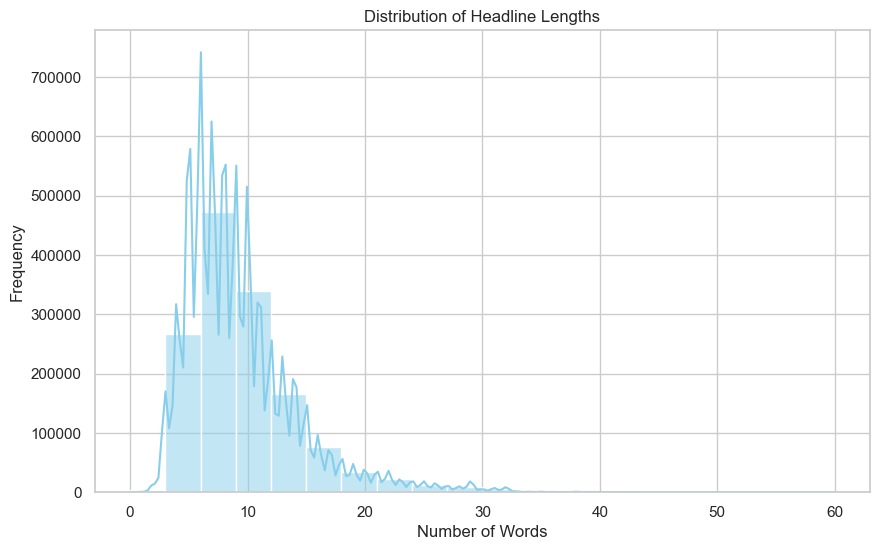

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add a new column for headline length
df["headline_length"] = df["cleaned_headline"].apply(lambda x: len(x.split()))

# Descriptive statistics
print("Headline Length Stats:")
print(df["headline_length"].describe())

# Plot distribution of headline lengths
plt.figure(figsize=(10,6))
sns.histplot(df["headline_length"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Headline Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Top 10 publishers by article count:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_7696\3322228085.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.head(10).values, y=publisher_counts.head(10).index, palette="viridis")


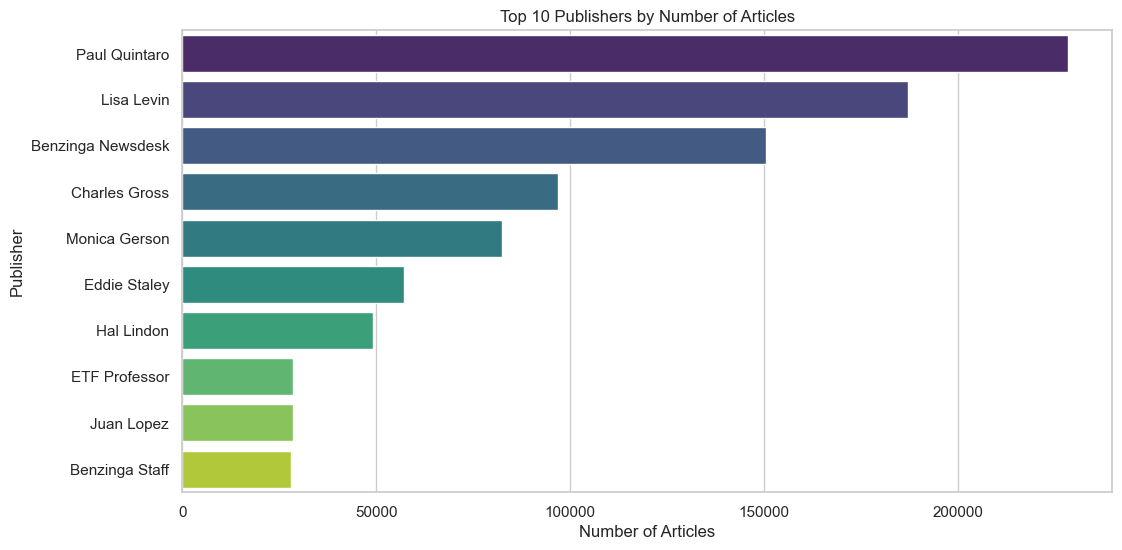

In [9]:
# Count articles per publisher
publisher_counts = df['publisher'].value_counts()

# Show top 10 publishers
print("Top 10 publishers by article count:")
print(publisher_counts.head(10))

# Plot the top 10 publishers
plt.figure(figsize=(12,6))
sns.barplot(x=publisher_counts.head(10).values, y=publisher_counts.head(10).index, palette="viridis")
plt.title("Top 10 Publishers by Number of Articles")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()


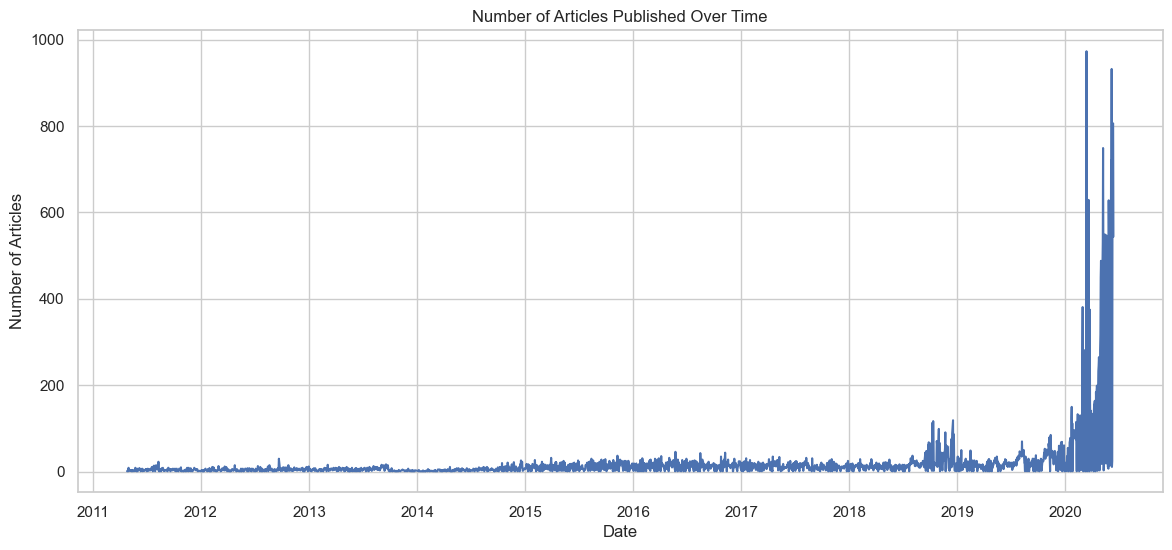

In [10]:
# Ensure date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Count articles per day
daily_counts = df.groupby(df['date'].dt.date).size()

# Plot article frequency over time
plt.figure(figsize=(14,6))
daily_counts.plot()
plt.title("Number of Articles Published Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()

Top 20 words in headlines:
vs: 162061
stocks: 161868
est: 140578
eps: 128910
shares: 114181
reports: 108705
update: 91680
market: 90873
earnings: 87184
sales: 79524
top: 78644
pt: 73043
announces: 66528
price: 64231
buy: 64003
downgrades: 61942
trading: 61151
raises: 57798
upgrades: 56804
benzingas: 54907


C:\Users\HP\AppData\Local\Temp\ipykernel_7696\411261169.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_words_df, palette="viridis")


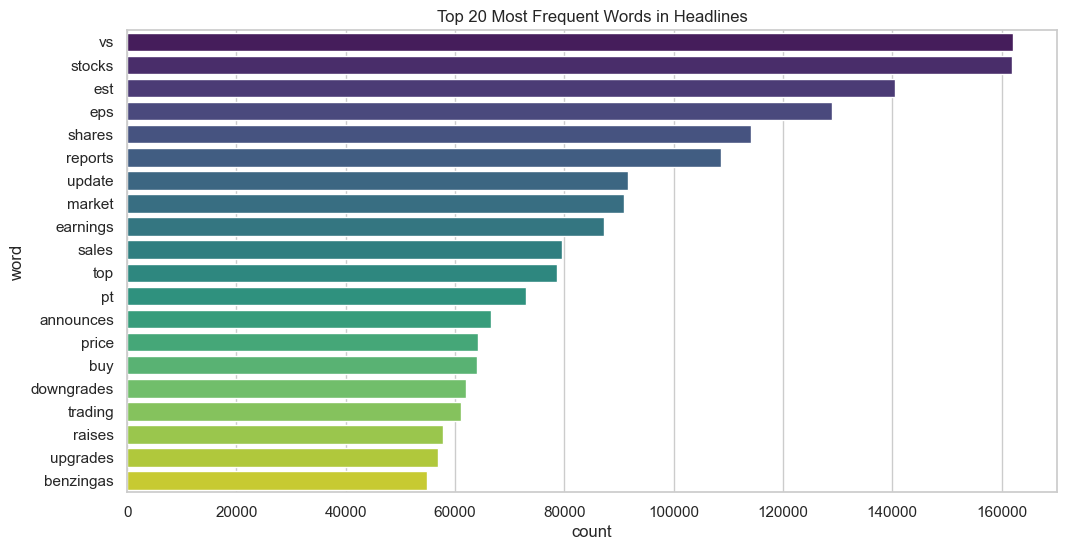

In [11]:
from collections import Counter

# Combine all cleaned headlines into one big list of words
all_words = " ".join(df['cleaned_headline']).split()

# Count frequency of each word
word_freq = Counter(all_words)

# Get top 20 most common words
top_words = word_freq.most_common(20)
print("Top 20 words in headlines:")
for word, freq in top_words:
    print(f"{word}: {freq}")

# Optional: visualize with a barplot
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])
plt.figure(figsize=(12,6))
sns.barplot(x='count', y='word', data=top_words_df, palette="viridis")
plt.title("Top 20 Most Frequent Words in Headlines")
plt.show()


In [12]:

from gensim import corpora, models
import random
# Taking only 50000 sample becasue the whole data set is large it hasn't be excuted for more than 30 mim
sample_df = df.sample(n=50000, random_state=42)

# Tokenize headlines
tokenized_headlines = [headline.split() for headline in sample_df['cleaned_headline']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_headlines)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_headlines]

# Run LDA with fewer passes
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=5, random_state=42)

# Show topics
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx+1}: {topic}")


Topic 1: 0.033*"earnings" + 0.026*"market" + 0.025*"stocks" + 0.023*"top" + 0.021*"benzingas" + 0.017*"session" + 0.016*"update" + 0.016*"moving" + 0.015*"premarket" + 0.014*"scheduled"
Topic 2: 0.036*"stocks" + 0.026*"shares" + 0.022*"trading" + 0.020*"new" + 0.020*"52week" + 0.013*"companies" + 0.013*"higher" + 0.011*"4" + 0.010*"lower" + 0.010*"several"
Topic 3: 0.073*"vs" + 0.064*"est" + 0.059*"eps" + 0.050*"reports" + 0.038*"sales" + 0.019*"q1" + 0.018*"sees" + 0.018*"q2" + 0.018*"q4" + 0.017*"estimate"
Topic 4: 0.013*"says" + 0.011*"alert" + 0.011*"group" + 0.011*"option" + 0.008*"etfs" + 0.008*"deal" + 0.007*"us" + 0.007*"etf" + 0.007*"ask" + 0.006*"calls"
Topic 5: 0.024*"pt" + 0.021*"buy" + 0.020*"downgrades" + 0.020*"announces" + 0.018*"upgrades" + 0.018*"maintains" + 0.018*"target" + 0.018*"price" + 0.018*"raises" + 0.017*"update"


In [13]:
from gensim import corpora, models

tokenized_headlines = [headline.split() for headline in sample_df['cleaned_headline']]

dictionary = corpora.Dictionary(tokenized_headlines)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_headlines]

lda_model = models.LdaModel(corpus=corpus,
                            id2word=dictionary,
                            num_topics=5, 
                            random_state=42,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)
for i, topic in lda_model.print_topics():
    print(f"Topic {i}: {topic}")


Topic 0: 0.033*"earnings" + 0.030*"market" + 0.025*"stocks" + 0.024*"top" + 0.021*"benzingas" + 0.017*"session" + 0.015*"moving" + 0.015*"update" + 0.014*"premarket" + 0.014*"scheduled"
Topic 1: 0.035*"stocks" + 0.027*"shares" + 0.022*"trading" + 0.020*"new" + 0.019*"52week" + 0.013*"companies" + 0.013*"higher" + 0.011*"4" + 0.010*"lower" + 0.010*"several"
Topic 2: 0.078*"vs" + 0.068*"est" + 0.063*"eps" + 0.053*"reports" + 0.041*"sales" + 0.020*"q1" + 0.019*"sees" + 0.019*"q2" + 0.019*"q4" + 0.019*"estimate"
Topic 3: 0.013*"alert" + 0.013*"option" + 0.010*"says" + 0.009*"etfs" + 0.008*"ask" + 0.007*"etf" + 0.007*"calls" + 0.007*"shows" + 0.007*"oi" + 0.007*"contract"
Topic 4: 0.022*"pt" + 0.021*"announces" + 0.019*"buy" + 0.018*"downgrades" + 0.017*"raises" + 0.017*"upgrades" + 0.017*"target" + 0.017*"maintains" + 0.017*"price" + 0.016*"update"


In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)
